# Image Classification Model Training with VGG16

## Import Libraries

In [1]:
# Import Libraries
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import pandas as pd
from PIL import Image

## Set Data Directories

In [2]:
# Set Directories
train_ds = "./image/train"
test_ds = "./image/test"
validation_ds = "./image/valid"


## Load and Visualize Data

Found 3208 images belonging to 20 classes.


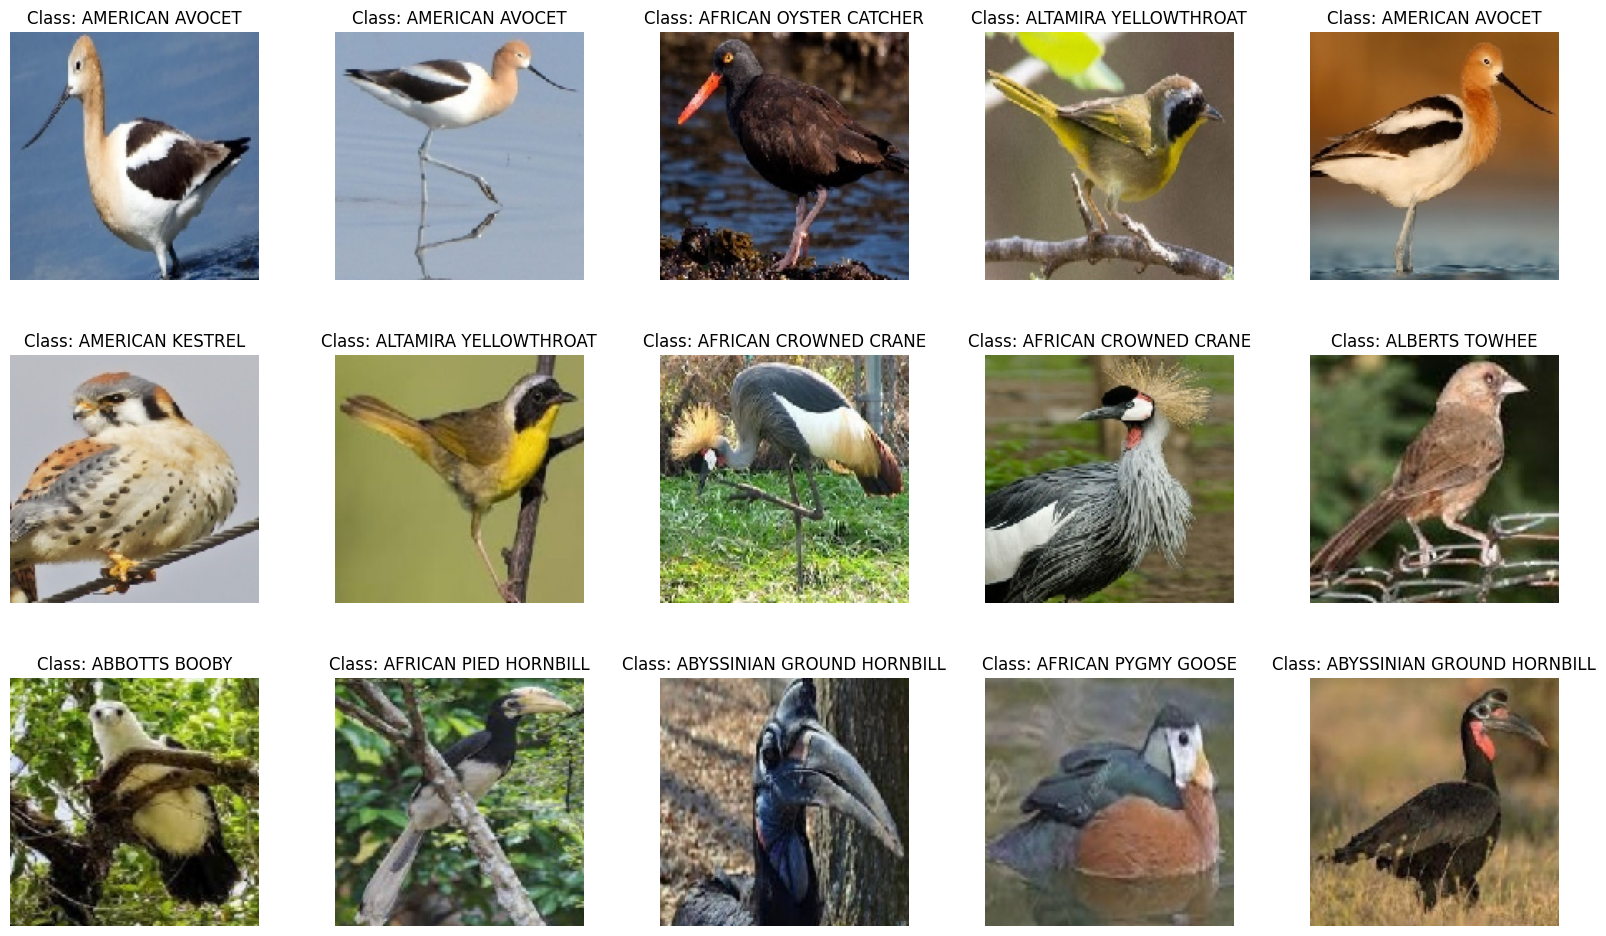

In [3]:
# Load sample data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_ds, target_size=(150, 150), batch_size=32, class_mode='categorical')

# Visualize a few images and labels
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images, titles = sample_generate[0], sample_generate[1]

plt.figure(figsize=(20, 20))
for i in range(15):
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i], axis=0)]}')
    plt.axis("off")
plt.show()


## Initialize Data Generators with Augmentation

In [4]:
# Initialize the data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Create data generators
train_generator = train_datagen.flow_from_directory(train_ds, target_size=(150, 150), batch_size=32, class_mode='categorical')
validation_generator = valid_datagen.flow_from_directory(validation_ds, target_size=(150, 150), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_ds, target_size=(150, 150), batch_size=32, class_mode='categorical')


Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


## Load VGG16 Model

In [5]:
# Load the VGG16 model with pre-trained weights
base_model = VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Keep layers frozen for transfer learning


## Define the Model

In [6]:
# Define the model
seq_model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(labels), activation='softmax')  # Adjust the number of units based on your class count
])


## Model Summary

In [7]:
# Model Summary
seq_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,817,236 (64.15 MB)

 Trainable params: 2,102,548 (8.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compile the Model

In [8]:
# Compile the model
seq_model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


## Train the Model

In [9]:
# Initialize EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = seq_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


d:\kode random\Web Bu akhsin\Streamlit\stenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 697ms/step - accuracy: 0.1386 - loss: 2.8862 - val_accuracy: 0.5100 - val_loss: 2.0559
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 655ms/step - accuracy: 0.4119 - loss: 2.1788 - val_accuracy: 0.6700 - val_loss: 1.4941
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 68s 671ms/step - accuracy: 0.5564 - loss: 1.6959 - val_accuracy: 0.7100 - val_loss: 1.1930
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 715ms/step - accuracy: 0.6215 - loss: 1.4413 - val_accuracy: 0.7400 - val_loss: 0.9773
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 74s 736ms/step - accuracy: 0.6527 - loss: 1.2885 - val_accuracy: 0.7600 - val_loss: 0.8370
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 71s 702ms/step - accuracy: 0.6775 - loss: 1.1731 - val_accuracy: 0.7700 - val_loss: 0.7685
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 69s 683ms/step - accuracy: 0.7119 - loss: 1.0925 - val_accuracy: 0.8100 - val_loss: 0.6428
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 70s 695ms/step - accuracy: 0.7185 - loss: 1

## Visualize Training Results

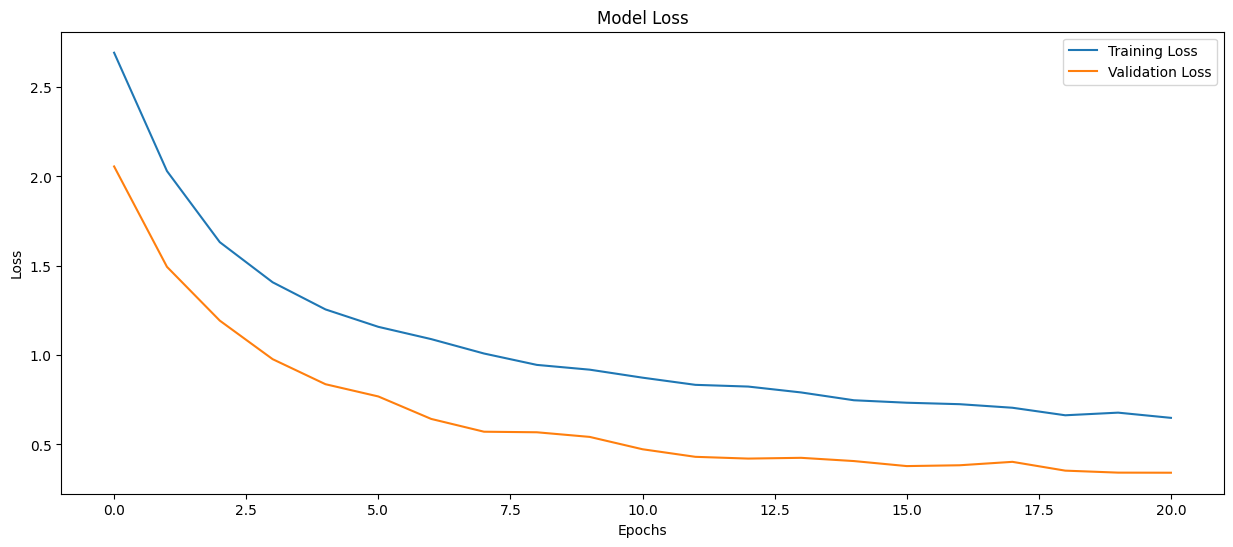

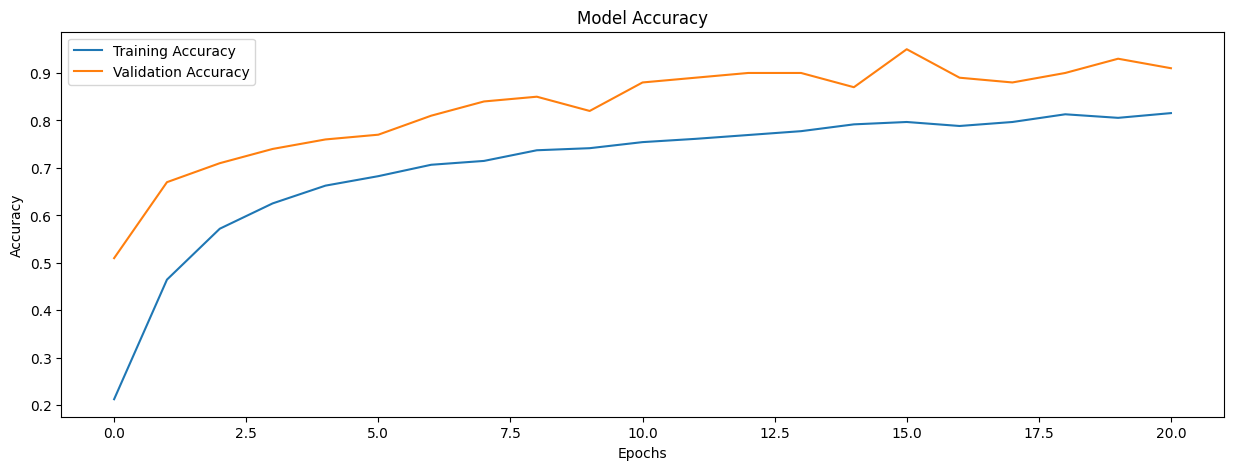

In [10]:
# Convert the history to a DataFrame
results = pd.DataFrame(history.history)

# Plot Loss
plt.figure(figsize=(15, 6))
plt.plot(results['loss'], label='Training Loss')
plt.plot(results['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(15, 5))
plt.plot(results['accuracy'], label='Training Accuracy')
plt.plot(results['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Evaluate the Model

In [11]:
# Evaluate the model
results = seq_model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.8643 - loss: 0.4167
Test Loss: 0.38011085987091064
Test Accuracy: 0.8899999856948853


## Generate Classification Report

In [12]:
# Get predictions and true labels
y_test_1 = test_generator.classes
y_pred_1 = seq_model.predict(test_generator)
y_pred_1 = np.argmax(y_pred_1, axis=1)

# Generate classification report
print(classification_report(y_test_1, y_pred_1, target_names=labels))


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.00      0.00      0.00         5
             ABBOTTS BOOBY       0.00      0.00      0.00         5
ABYSSINIAN GROUND HORNBILL       0.00      0.00      0.00         5
     AFRICAN CROWNED CRANE       0.00      0.00      0.00         5
    AFRICAN EMERALD CUCKOO       0.00      0.00      0.00         5
         AFRICAN FIREFINCH       0.00      0.00      0.00         5
    AFRICAN OYSTER CATCHER       0.00      0.00      0.00         5
     AFRICAN PIED HORNBILL       0.00      0.00      0.00         5
       AFRICAN PYGMY GOOSE       0.00      0.00      0.00         5
                 ALBATROSS       0.00      0.00      0.00         5
            ALBERTS TOWHEE       0.20      0.20      0.20         5
      ALEXANDRINE PARAKEET       0.00      0.00      0.00         5
             ALPINE CHOUGH       0.00      0.00      0.00         5
     ALT

## Save the Model

In [13]:
# Save the model
seq_model.save('model.h5')
print("Model saved as 'model.h5'")


Model saved as 'model.h5'


## Using the Model for Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


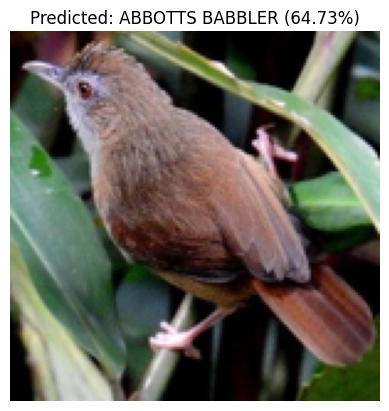

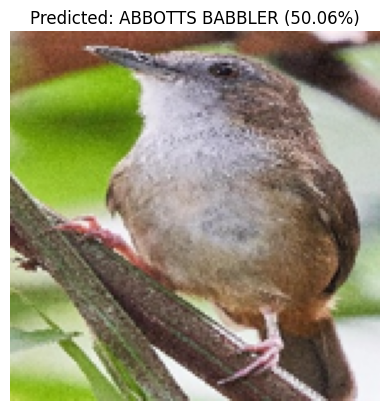

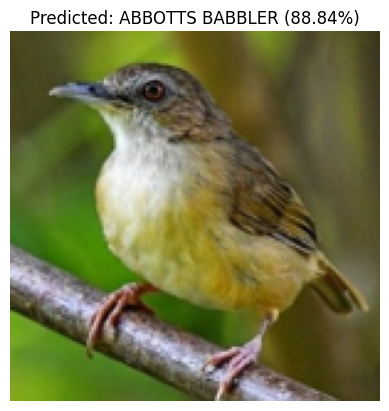

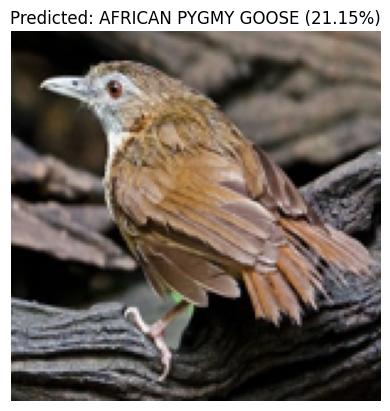

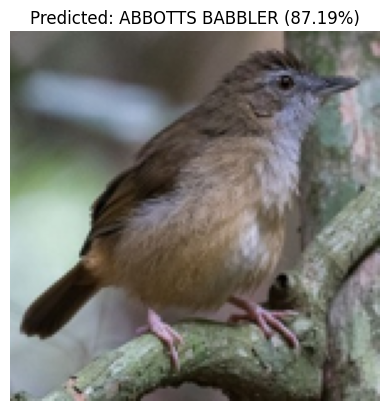

In [14]:
# Load images from test directory
image_directory = './image/test/ABBOTTS BABBLER'  # Adjust path as needed
img_size = 150

# Load and preprocess images
images = []
for filename in os.listdir(image_directory):
    path = os.path.join(image_directory, filename)
    img = Image.open(path)
    img = img.resize((img_size, img_size))
    images.append(img)

# Convert images to numpy array and scale values
images = np.array([np.array(img) for img in images])
images = images / 255.0

# Get predictions
predictions = seq_model.predict(images)

# Display predictions with class name and confidence percentage
for i, prediction in enumerate(predictions):
    class_index = np.argmax(prediction)
    class_name = labels[class_index]
    confidence = prediction[class_index] * 100
    
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Predicted: {class_name} ({confidence:.2f}%)")
    plt.show()